In [15]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from matplotlib import pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

### train

In [16]:
train_signal_path = 'C:/Users/rustem.kamilyanov/defectoscopy2/train/signal'
train_markup_path = 'C:/Users/rustem.kamilyanov/defectoscopy2/train/markup'

train_names = os.listdir(train_signal_path)

In [17]:
# FIX
def dataloader_train(batch_size, n_files, window, step):
    
    for name in train_names[:n_files]:
        signals = []

        # считываем npz файл, приводим к виду (N, 642, 2)
        temp_signals = load_npz(train_signal_path + '/' + name).toarray()
        temp_signals = np.stack([temp_signals[:, :642], temp_signals[:, 642:]], axis=2)

        # для каждой матрицы (642, 2) поэлементо складываем столбцы, 
        # получаем общий вектор (642, )
        for matrix in temp_signals:
            temp = []
            for a, b in zip(matrix[:, 0], matrix[:, 1]):
                temp.append(max(a, b))
            signals.append(temp)

        # из полученных векторов формируем массив array (N, 642)
        temp_signals = np.array(signals)

        # считываем лейблы
        temp_labels = load_npz(train_markup_path + '/' + name).toarray()

        # объединяем полученный массив array с лейблами, получаем массив (N, 643)
        # в котором последний столбец - лейблы
        df_train = np.concatenate([temp_signals, temp_labels.reshape(-1, 1)], axis=1)

        # скользящим окном шириной 500 и шагом 100 разбиваем полученный массив на части
        window = window
        step = step
        parts_x = []
        parts_y = []
        for idx in range(0, len(df_train)-window, step):
            idx_left = idx
            idx_right = idx + window
            
            if len(parts_y) == batch_size:
                parts_x = []
                parts_y = []
                
            if len(np.unique(df_train[idx_left:idx_right, -1])) == 1:
                parts_x.append(df_train[idx_left:idx_right, :-1])
                parts_y.append(df_train[idx_left:idx_right, -1][0])
            else:
                if len(np.unique(df_train[idx_left:idx_right, -1])) == 2 and \
                (0 in np.unique(df_train[idx_left:idx_right, -1])):
                    parts_x.append(df_train[idx_left:idx_right, :-1])
                    parts_y.append(df_train[idx_left:idx_right, -1][1])
                else:
                    if len(np.unique(df_train[idx_left:idx_right, -1])) > 2:
                        #parts_x.append(df_train[idx_left:idx_right, :-1])
                        #parts_y.append(1)
                        pass
                    
            if len(parts_y) == batch_size:
                for idx, label in enumerate(parts_y):
                    if label == 2:
                        parts_y[idx] = 1
                    elif label == 3:
                            parts_y[idx] = 2
                    elif label == 5:
                        parts_y[idx] = 3
                    elif label == 6:
                        parts_y[idx] = 4
                
                yield [torch.tensor(parts_x, dtype=torch.float),
                      torch.tensor(parts_y, dtype=torch.long)]

#0->0
#2->1 
#3->2 
#5->3 
#6->4

### test

In [18]:
test_signal_path = 'C:/Users/rustem.kamilyanov/defectoscopy2/test/signal'
test_markup_path = 'C:/Users/rustem.kamilyanov/defectoscopy2/test/markup'

test_names = os.listdir(test_signal_path)

In [19]:
def dataloader_test(batch_size, n_files, window, step):
    
    for name in test_names[:n_files]:
        signals = []

        # считываем npz файл, приводим к виду (N, 642, 2)
        temp_signals = load_npz(test_signal_path + '/' + name).toarray()
        temp_signals = np.stack([temp_signals[:, :642], temp_signals[:, 642:]], axis=2)

        # для каждой матрицы (642, 2) поэлементо складываем столбцы, получаем общий вектор (642, )
        for matrix in temp_signals:
            temp = []
            for a, b in zip(matrix[:, 0], matrix[:, 1]):
                temp.append(max(a, b))
            signals.append(temp)

        # из полученных векторов формируем массив array (N, 642)
        temp_signals = np.array(signals)

        # считываем лейблы
        temp_labels = load_npz(test_markup_path + '/' + name).toarray()

        # объединяем полученный массив array с лейблами, получаем массив (N, 643)
        # в котором последний столбец - лейблы
        df_test = np.concatenate([temp_signals, temp_labels.reshape(-1, 1)], axis=1)

        # скользящим окном шириной 500 и шагом 100 разбиваем полученный массив на части
        window = window
        step = step
        parts_x = []
        parts_y = []
        for idx in range(0, len(df_test)-window, step):
            idx_left = idx
            idx_right = idx + window
            
            if len(parts_x) == batch_size:
                parts_x = []
                parts_y = []
            
            if len(np.unique(df_test[idx_left:idx_right, -1])) == 1:
                parts_x.append(df_test[idx_left:idx_right, :-1])
                parts_y.append(df_test[idx_left:idx_right, -1][0])
            else:
                if len(np.unique(df_test[idx_left:idx_right, -1])) == 2 and \
                (0 in np.unique(df_test[idx_left:idx_right, -1])):
                    parts_x.append(df_test[idx_left:idx_right, :-1])
                    parts_y.append(df_test[idx_left:idx_right, -1][1])
                else:
                    if len(np.unique(df_test[idx_left:idx_right, -1])) > 2:
                        #parts_x.append(df_test[idx_left:idx_right, :-1])
                        #parts_y.append(1)
                        pass
                        
            if len(parts_y) == batch_size:
                for idx, label in enumerate(parts_y):
                    if label == 2:
                        parts_y[idx] = 1
                    elif label == 3:
                            parts_y[idx] = 2
                    elif label == 5:
                        parts_y[idx] = 3
                    elif label == 6:
                        parts_y[idx] = 4              
                
                yield [torch.tensor(parts_x, dtype=torch.float),
                      torch.tensor(parts_y, dtype=torch.long)]

In [21]:
def dataloader_test_viz(batch_size, n_files, window, step):
    
    for name in test_names[:n_files]:
        signals = []

        # считываем npz файл, приводим к виду (N, 642, 2)
        temp_signals = load_npz(test_signal_path + '/' + name).toarray()
        temp_signals = np.stack([temp_signals[:, :642], temp_signals[:, 642:]], axis=2)

        # для каждой матрицы (642, 2) поэлементо складываем столбцы, получаем общий вектор (642, )
        for matrix in temp_signals:
            temp = []
            for a, b in zip(matrix[:, 0], matrix[:, 1]):
                temp.append(max(a, b))
            signals.append(temp)

        # из полученных векторов формируем массив array (N, 642)
        temp_signals = np.array(signals)

        # считываем лейблы
        temp_labels = load_npz(test_markup_path + '/' + name).toarray()

        # объединяем полученный массив array с лейблами, получаем массив (N, 643)
        # в котором последний столбец - лейблы
        df_test = np.concatenate([temp_signals, temp_labels.reshape(-1, 1)], axis=1)

        # скользящим окном шириной 500 и шагом 100 разбиваем полученный массив на части
        window = window
        step = step
        parts_x = []
        parts_y = []
        for idx in range(0, len(df_test)-window, step):
            idx_left = idx
            idx_right = idx + window
            
            if len(parts_x) == batch_size:
                parts_x = []
                parts_y = []
            
            parts_x.append(df_test[idx_left:idx_right, :-1])
            parts_y.append(0)
                            
            if len(parts_y) == batch_size:                
                yield [torch.tensor(parts_x, dtype=torch.float),
                      torch.tensor(parts_y, dtype=torch.long)]

### DataLoader

In [22]:
from torch.utils.data import Dataset
class SignalLabelDatset(Dataset):
    def __init__(self, signals, labels):
        super(SignalLabelDatset, self).__init__()
        self.signals = signals
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

In [23]:
from torch.utils.data import DataLoader
class RNNData(object):
    def __init__(self, train_x, train_y, test_x, test_y, batch_size):
        self.batch_size = batch_size
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
    
    def get_train(self):
        dataset = SignalLabelDatset(signals=self.train_x, labels=self.train_y)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    
    def get_test(self):
        dataset = SignalLabelDatset(signals=self.test_x, labels=self.test_y)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

### Eval

In [24]:
def eval_model(model, test, loss_func):
    val_loss_batch = []
    
    class_recognition = {'class_0_hit': [], 'class_0_true': [], 
                         'class_2_hit': [], 'class_2_true': [], 
                         'class_3_hit': [], 'class_3_true': [], 
                         'class_5_hit': [], 'class_5_true': [], 
                         'class_6_hit': [], 'class_6_true': []}
    
    eval_metrics = {'val_loss_test': None, 
                    'class_0': None, 'class_2': None,
                    'class_3': None, 'class_5': None, 'class_6': None}
    
    model.eval()
    with torch.no_grad():
        for x, y in test:
            # loss on valid set
            raw_predict = model(x.to(device))
            loss = loss_func(raw_predict, y.reshape(-1).to(device))
            val_loss_batch.append(loss.item())
            
            # class recognition
            probs = nn.Softmax(dim=1)(raw_predict)
            predict_labels = [torch.argmax(label).item() for label in probs]
            true_labels = y.reshape(-1).tolist()
            
            for label_predict, label_true in zip(predict_labels, true_labels):
                if (label_true == 0) and (label_true == label_predict):
                    class_recognition['class_0_true'].append(1)
                    class_recognition['class_0_hit'].append(1)
                elif (label_true == 0) and (label_true != label_predict):
                    class_recognition['class_0_true'].append(1)
                    class_recognition['class_0_hit'].append(0)
                elif (label_true == 1) and (label_true == label_predict):
                    class_recognition['class_2_true'].append(1)
                    class_recognition['class_2_hit'].append(1)
                elif (label_true == 1) and (label_true != label_predict):
                    class_recognition['class_2_true'].append(1)
                    class_recognition['class_2_hit'].append(0)
                elif (label_true == 2) and (label_true == label_predict):
                    class_recognition['class_3_true'].append(1)
                    class_recognition['class_3_hit'].append(1)
                elif (label_true == 2) and (label_true != label_predict):
                    class_recognition['class_3_true'].append(1)
                    class_recognition['class_3_hit'].append(0)
                elif (label_true == 3) and (label_true == label_predict):
                    class_recognition['class_5_true'].append(1)
                    class_recognition['class_5_hit'].append(1)
                elif (label_true == 3) and (label_true != label_predict):
                    class_recognition['class_5_true'].append(1)
                    class_recognition['class_5_hit'].append(0)
                elif (label_true == 4) and (label_true == label_predict):
                    class_recognition['class_6_true'].append(1)
                    class_recognition['class_6_hit'].append(1)
                elif (label_true == 4) and (label_true != label_predict):
                    class_recognition['class_6_true'].append(1)
                    class_recognition['class_6_hit'].append(0)
            
        eval_metrics['class_0'] = round(sum(class_recognition['class_0_hit']) / 
                                        sum(class_recognition['class_0_true']), 2)
        eval_metrics['class_2'] = round(sum(class_recognition['class_2_hit']) / 
                                        sum(class_recognition['class_2_true']), 2)
        eval_metrics['class_3'] = round(sum(class_recognition['class_3_hit']) / 
                                        sum(class_recognition['class_3_true']), 2)
        eval_metrics['class_5'] = round(sum(class_recognition['class_5_hit']) / 
                                        sum(class_recognition['class_5_true']), 2)
        eval_metrics['class_6'] = round(sum(class_recognition['class_6_hit']) / 
                                        sum(class_recognition['class_6_true']), 2)
              
        eval_metrics['val_loss_test'] = (sum(val_loss_batch)/len(val_loss_batch))
        
        
        return eval_metrics

### Pipe

In [25]:
from IPython.display import clear_output

def train_pipeline(model, dataloader, optimizer, loss_func,
                   num_epochs, num_layers, bidirectional):
    train_loss_history = []
    test_loss_history = []
    class_recognition_history = {'class_0': [], 'class_2': [],
                                 'class_3': [], 'class_5': [], 'class_6': [],}
    test = dataloader.get_test()

    for idx_epoch in range(num_epochs):
        model.train()
        train = dataloader.get_train()
        
        loss_batch = []
        for x, y in tqdm(train, desc=f'[Epoch #{idx_epoch}]', total=len(train)):
            optimizer.zero_grad()

            if bidirectional:
                model.hidden_cell = (torch.zeros(num_layers*2, 1, model.hidden_layer_size),
                                     torch.zeros(num_layers*2, 1, model.hidden_layer_size))
            else:
                model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size),
                                     torch.zeros(num_layers, 1, model.hidden_layer_size))

            
            y_hat = model(x.to(device))
            loss = loss_func(y_hat, y.reshape(-1).to(device))
            loss.backward()
            optimizer.step()
            loss_batch.append(loss.item())
        train_loss_history.append(sum(loss_batch)/len(loss_batch))
        
        # Eval
        metrics = eval_model(model, test, loss_func)
        
        test_loss_history.append(metrics['val_loss_test'])
        class_recognition_history['class_0'].append(metrics['class_0'])
        class_recognition_history['class_2'].append(metrics['class_2'])
        class_recognition_history['class_3'].append(metrics['class_3'])
        class_recognition_history['class_5'].append(metrics['class_5'])
        class_recognition_history['class_6'].append(metrics['class_6'])
        
        if idx_epoch % 1 == 0:
            clear_output(True)
            plt.figure(figsize=(15,5))
            plt.plot(train_loss_history, label='LOSS', c='red')
            plt.plot(test_loss_history, label='LOSS_Val', c='green')
            plt.grid()

            plt.title(f'LOSS: {train_loss_history[idx_epoch]:.3f}, \
                        LOSS_Val: {test_loss_history[idx_epoch]:.3f}')
            plt.legend()
            plt.show()
            
            plt.figure(figsize=(15,5))
            plt.plot(class_recognition_history['class_0'], label='class_0')
            plt.plot(class_recognition_history['class_2'], label='class_2')
            plt.plot(class_recognition_history['class_3'], label='class_3')
            plt.plot(class_recognition_history['class_5'], label='class_5')
            plt.plot(class_recognition_history['class_6'], label='class_6')
            plt.title('Class Recognition')
            plt.legend()
            plt.show()

# Conv Layers & LSTM

### Model

In [34]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_layers, bidirectional, dropout, 
                 input_size, hidden_layer_size, output_size):
        super(CNN_LSTM, self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.conv = nn.Conv2d(1, 1, (3,3), stride=2)
        self.bn2d = nn.BatchNorm2d(1)
        self.bn1d = nn.BatchNorm1d(1170)
        self.avrg2d = nn.AvgPool2d((3,3), stride=2)
        self.linear_cnn = nn.Linear(1170, input_size)
        
        # CNN
        self.seq_conv = nn.ModuleList()
        
        for idx in range(2):
            self.seq_conv.append(self.conv)
            self.seq_conv.append(self.bn2d)
            self.seq_conv.append(nn.ReLU())
            self.seq_conv.append(self.avrg2d)
        
        self.seq_conv.append(nn.Flatten())
        self.seq_conv.append(self.bn1d)
        self.seq_conv.append(self.linear_cnn)

        
        # LSTM
        if bidirectional:
            self.hidden_cell = (torch.zeros(num_layers*2, 1, hidden_layer_size),
                                torch.zeros(num_layers*2, 1, hidden_layer_size))
            self.lstm_list = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, 
                                     num_layers=num_layers, bidirectional=bidirectional, 
                                     dropout=dropout)
            self.linear_lstm = nn.Linear(hidden_layer_size*2, output_size)
        else:
            self.hidden_cell = (torch.zeros(num_layers, 1, hidden_layer_size),
                                torch.zeros(num_layers, 1, hidden_layer_size))
            self.lstm_list = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, 
                                     num_layers=num_layers, bidirectional=bidirectional, 
                                     dropout=dropout)
            self.linear_lstm = nn.Linear(hidden_layer_size, output_size)

        
    def forward(self, x):
        #CNN
        for layer in self.seq_conv:
            x = layer(x)
        
        #LSTM    
        lstm_out, self.hidden_cell = self.lstm_list(x.view(len(x), 1, -1),
                                                    self.hidden_cell)
        predictions = self.linear_lstm(lstm_out.view(len(x), -1))
        return predictions

    # * визуализация прогнозов
    # * брать Max по каждой точке при объед каналов
    # заменить LSTM полносвязным (Linear)

### Формируем train и test

In [28]:
train_x = []
train_y = []
for x, y in dataloader_train(1, n_files=10, window=500, step=100):
    train_x.append(x)
    train_y.append(y)

test_x = []
test_y = []
for x, y in dataloader_test(1, n_files=5, window=500, step=100):
    test_x.append(x)
    test_y.append(y)

<ipython-input-17-f1b87e364894>:68: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(parts_y, dtype=torch.long)]
<ipython-input-19-6fd3c59d0431>:66: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  torch.tensor(parts_y, dtype=torch.long)]


In [29]:
pd.Series([x.item() for x in test_y]).value_counts()

0    593
1     37
4     18
3     15
2     12
dtype: int64

In [30]:
pd.Series([x.item() for x in train_y]).value_counts()

0    388
1     17
3     10
4      8
2      2
dtype: int64

In [31]:
pd.Series([x.item() for x in train_y]).value_counts(normalize=True)

0    0.912941
1    0.040000
3    0.023529
4    0.018824
2    0.004706
dtype: float64

In [32]:
pd.Series([x.item() for x in test_y]).value_counts(normalize=True)

0    0.878519
1    0.054815
4    0.026667
3    0.022222
2    0.017778
dtype: float64

### Обучаем модель

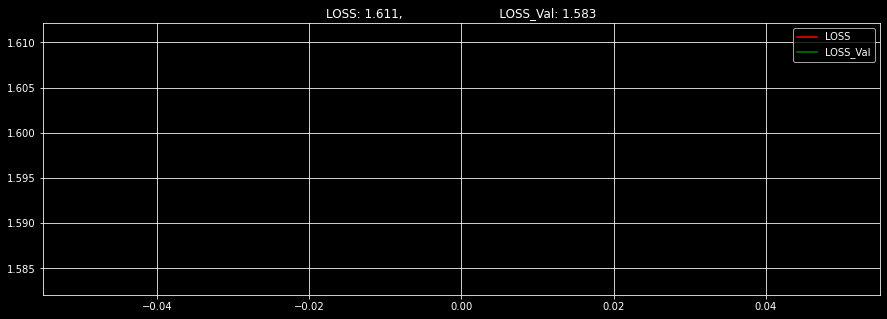

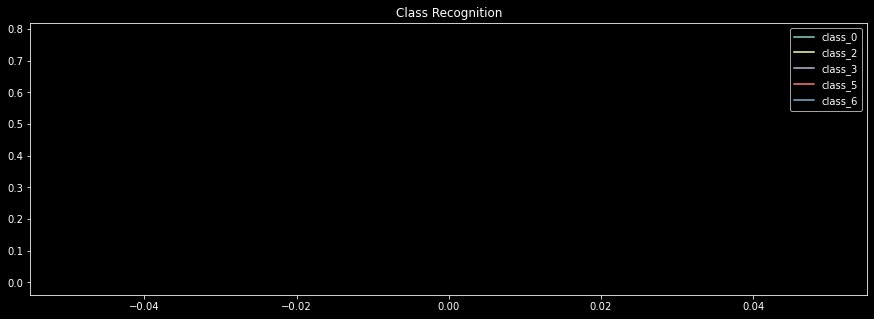

In [35]:
torch.manual_seed(1411)
# params
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 16
lr = 1e-4 # 1e-6, *1e-4
num_epochs = 1 # *10
n_layers = 2 # *1
input_size = 642
hidden_layer_size = 642 # 300, 50, *10
output_size = 5
bidirectional = True
dropout= 0.5 # 0.2

model = CNN_LSTM(num_layers=n_layers, input_size=input_size, 
             hidden_layer_size=hidden_layer_size, output_size=output_size, 
             bidirectional=bidirectional, dropout=dropout)

dataloader = RNNData(train_x=train_x, train_y=train_y,
                     test_x=test_x, test_y=test_y,
                     batch_size=batch_size)

optimizer = optim.Adam(model.parameters(), lr=lr)

w0 = (1-0.918579)/0.918579
w1 = (1-0.033309)/0.033309
w2 = (1-0.011843)/0.011843
w3 = (1-0.027387)/0.027387
w4 = (1-0.008882)/0.008882
w = torch.tensor([w0, w1, w2, w3, w4], dtype=torch.float32)
loss_func = nn.CrossEntropyLoss(weight=w)

train_pipeline(model=model, dataloader=dataloader, optimizer=optimizer,
               loss_func=loss_func, num_epochs=num_epochs, num_layers=n_layers,
               bidirectional=bidirectional)


In [41]:
x, y = next(iter(dataloader.get_test()))
raw_predict = model(x)
raw_predict

tensor([[ 0.0387,  0.1587, -0.1628, -0.0132,  0.0598],
        [ 0.0344,  0.1618, -0.1673, -0.0138,  0.0685],
        [ 0.0386,  0.1660, -0.1622, -0.0143,  0.0591],
        [ 0.0413,  0.1692, -0.1574, -0.0144,  0.0494],
        [ 0.0407,  0.1763, -0.1574, -0.0153,  0.0520],
        [ 0.0411,  0.1740, -0.1533, -0.0102,  0.0516],
        [ 0.0386,  0.1755, -0.1562, -0.0116,  0.0501],
        [ 0.0401,  0.1710, -0.1530, -0.0117,  0.0495],
        [ 0.0429,  0.1642, -0.1463, -0.0077,  0.0414],
        [ 0.0482,  0.1489, -0.1422, -0.0067,  0.0401],
        [ 0.0533,  0.1350, -0.1360,  0.0034,  0.0300],
        [ 0.0529,  0.1241, -0.1292,  0.0096,  0.0282],
        [ 0.0484,  0.1257, -0.1328,  0.0079,  0.0307],
        [ 0.0500,  0.1315, -0.1330, -0.0046,  0.0381],
        [ 0.0544,  0.1324, -0.1293, -0.0163,  0.0397],
        [ 0.0615,  0.1218, -0.1273, -0.0197,  0.0338]],
       grad_fn=<AddmmBackward0>)

In [42]:
probs = nn.Softmax(dim=1)(raw_predict)
probs

tensor([[0.2034, 0.2294, 0.1663, 0.1931, 0.2078],
        [0.2024, 0.2299, 0.1654, 0.1929, 0.2094],
        [0.2031, 0.2307, 0.1662, 0.1927, 0.2073],
        [0.2037, 0.2314, 0.1670, 0.1926, 0.2053],
        [0.2031, 0.2327, 0.1666, 0.1921, 0.2055],
        [0.2030, 0.2319, 0.1671, 0.1928, 0.2051],
        [0.2027, 0.2325, 0.1669, 0.1928, 0.2051],
        [0.2031, 0.2315, 0.1675, 0.1929, 0.2050],
        [0.2038, 0.2301, 0.1687, 0.1938, 0.2035],
        [0.2053, 0.2271, 0.1697, 0.1943, 0.2036],
        [0.2066, 0.2242, 0.1709, 0.1965, 0.2018],
        [0.2066, 0.2218, 0.1722, 0.1978, 0.2015],
        [0.2059, 0.2224, 0.1718, 0.1977, 0.2023],
        [0.2061, 0.2236, 0.1716, 0.1951, 0.2036],
        [0.2070, 0.2238, 0.1723, 0.1929, 0.2040],
        [0.2090, 0.2220, 0.1730, 0.1927, 0.2033]], grad_fn=<SoftmaxBackward0>)

In [43]:
predict_labels = [torch.argmax(label).item() for label in probs]
predict_labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [44]:
true_labels = y.reshape(-1).tolist()
true_labels

[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0]

In [63]:
import itertools
permutations = list(itertools.permutations([0, 1, 2, 3, 4], 2))
permutations.extend([(0,0), (1,1), (2,2), (3,3), (4,4)])

In [70]:
conf_matrix_part = np.array([[0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0]])

for true_label, predict_label in zip(true_labels, predict_labels):
    for idx_conf_matrix_true, idx_conf_matrix_predict in permutations:
        if (true_label == idx_conf_matrix_true) and (predict_label == idx_conf_matrix_predict):
            conf_matrix_part[idx_conf_matrix_true, idx_conf_matrix_predict] += 1
        else:
            pass

In [78]:
l1 = [0, 1, 2]

In [84]:
d = {'abc': 0, 'defg': 1}
for key in d.keys():
    print(key)

abc
defg


In [72]:
conf_matrix_list = []
conf_matrix_list.append(conf_matrix_part)
conf_matrix_list.append(conf_matrix_part)
conf_matrix_list.append(conf_matrix_part)
conf_matrix_list.append(conf_matrix_part)


### Визуализация

In [25]:
def visualize(signal, spec_markup=None, pred_markup=None, start: int=0, end: int=0):   
    R = np.where(signal[:,:,0] > 0)
    B = np.where(signal[:,:,1] > 0)

    x_red = R[0]
    y_red = R[1]
    x_blu = B[0]
    y_blu = B[1]

    length = signal.shape[0]
    
    if spec_markup is None: 
        spec_markup = np.zeros(length)
    if pred_markup is None: 
        pred_markup = np.zeros(length)
    if end is None or end <= start:
        end = length
   
    interval_r = (x_red >= start) & (x_red <= end)
    interval_b = (x_blu >= start) & (x_blu <= end)

    fig = plt.figure(figsize=(20, 15), dpi=144)
    grid = plt.GridSpec(nrows=4, ncols=1, hspace=0.2, wspace=0.2)

    signal_plot = fig.add_subplot(grid[:-1, :])
    signal_plot.plot(x_red[interval_r], y_red[interval_r], 'rs', markersize=1.7)
    signal_plot.plot(x_blu[interval_b], y_blu[interval_b], 'bs', markersize=1.7)
    signal_plot.hlines([185,370,506], 0, length, colors='dimgray')
    signal_plot.set_xlim([start, end])
    signal_plot.set_ylim([0, 642])
    signal_plot.set_ylabel('Задержка сигнала (смещенная по каналам)', fontsize=18)
    signal_plot.tick_params(labelsize=16)
    
    markup_plot = fig.add_subplot(grid[-1, :], sharex=signal_plot)
    markup_plot.plot(spec_markup, color='red', label='Разметка специалиста')
    markup_plot.plot(pred_markup, color='blue', label='Разметка алгоритма')  
    markup_plot.set_ylim(0, 1.05)
    markup_plot.set_ylabel('Уверенность, %', fontsize=18)
    markup_plot.set_xlabel('Координата', fontsize=18)
    markup_plot.tick_params(labelsize=16)
    
    fig.suptitle(f'Визуализация разметки дефектных участков ({start} - {end})', y=0.95, fontsize=24)
    plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, fontsize=14)
    plt.close()

    return fig

In [26]:
def lable_seq(predict_labels, predict_confidence, seq_length, window, step):
    sequence = pd.Series(np.repeat(None, seq_length).tolist())
    predict_confidence = pd.Series(predict_confidence)
    for i in range(len(predict_labels)):
        idx_max = predict_confidence.idxmax()
        none_area = sequence.iloc[idx_max*step : idx_max*step+window].isnull()
        sequence.iloc[idx_max*step : idx_max*step+window][none_area] = predict_labels[idx_max]
        predict_confidence.drop(labels=[idx_max], inplace=True)
    sequence.dropna(inplace=True)
    return sequence

In [163]:
# достаем один тестовый файл
X = []
Y = []
for x, _ in dataloader_test_viz(1, n_files=1, window=1000, step=500):
    X.append(x)
    Y.append(y)

dl = RNNData(train_x=train_x, train_y=train_y,
             test_x=X, test_y=Y,
             batch_size=batch_size)

In [219]:
# получаем прогноз лейблов и соответствующие им вероятности
test = dl.get_test()
with torch.no_grad():
    model.eval()
    
    predict = []
    predict_confidence = []
    for x, _ in test:
        raw_predict = model(x)
        probs = nn.Softmax(dim=1)(raw_predict)
        predict.append([torch.argmax(label).item() for label in probs])
        predict_confidence.append([torch.max(prob).item() for prob in probs])

predict = [item for sublist in predict for item in sublist]
predict_labels = []
for label in predict:
    if label == 0:
        predict_labels.append(0)
    elif label == 1:
        predict_labels.append(2)
    elif label == 2:
        predict_labels.append(3)
    elif label == 3:
        predict_labels.append(5)
    elif label == 4:
        predict_labels.append(6)
    
predict_confidence = [item for sublist in predict_confidence for item in sublist]

In [220]:
pd.Series(predict_labels).value_counts()

0    15
5     9
2     8
6     1
dtype: int64

In [190]:
# сигнал и истинные лейблы
name = test_names[0]
signals = load_npz(test_signal_path + '/' + name).toarray()
signals = np.stack([signals[:, :642], signals[:, 642:]], axis=2)
true_labels = load_npz(test_markup_path + '/' + name).toarray()

In [221]:
sequence = lable_seq(predict_labels=predict_labels, predict_confidence=predict_confidence,
                     seq_length=len(true_labels.reshape(-1)), window=1000, step=500)

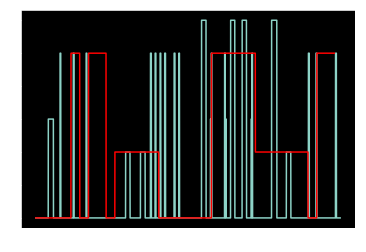

In [222]:
plt.plot(true_labels.reshape(-1))
plt.plot(sequence, color='red');

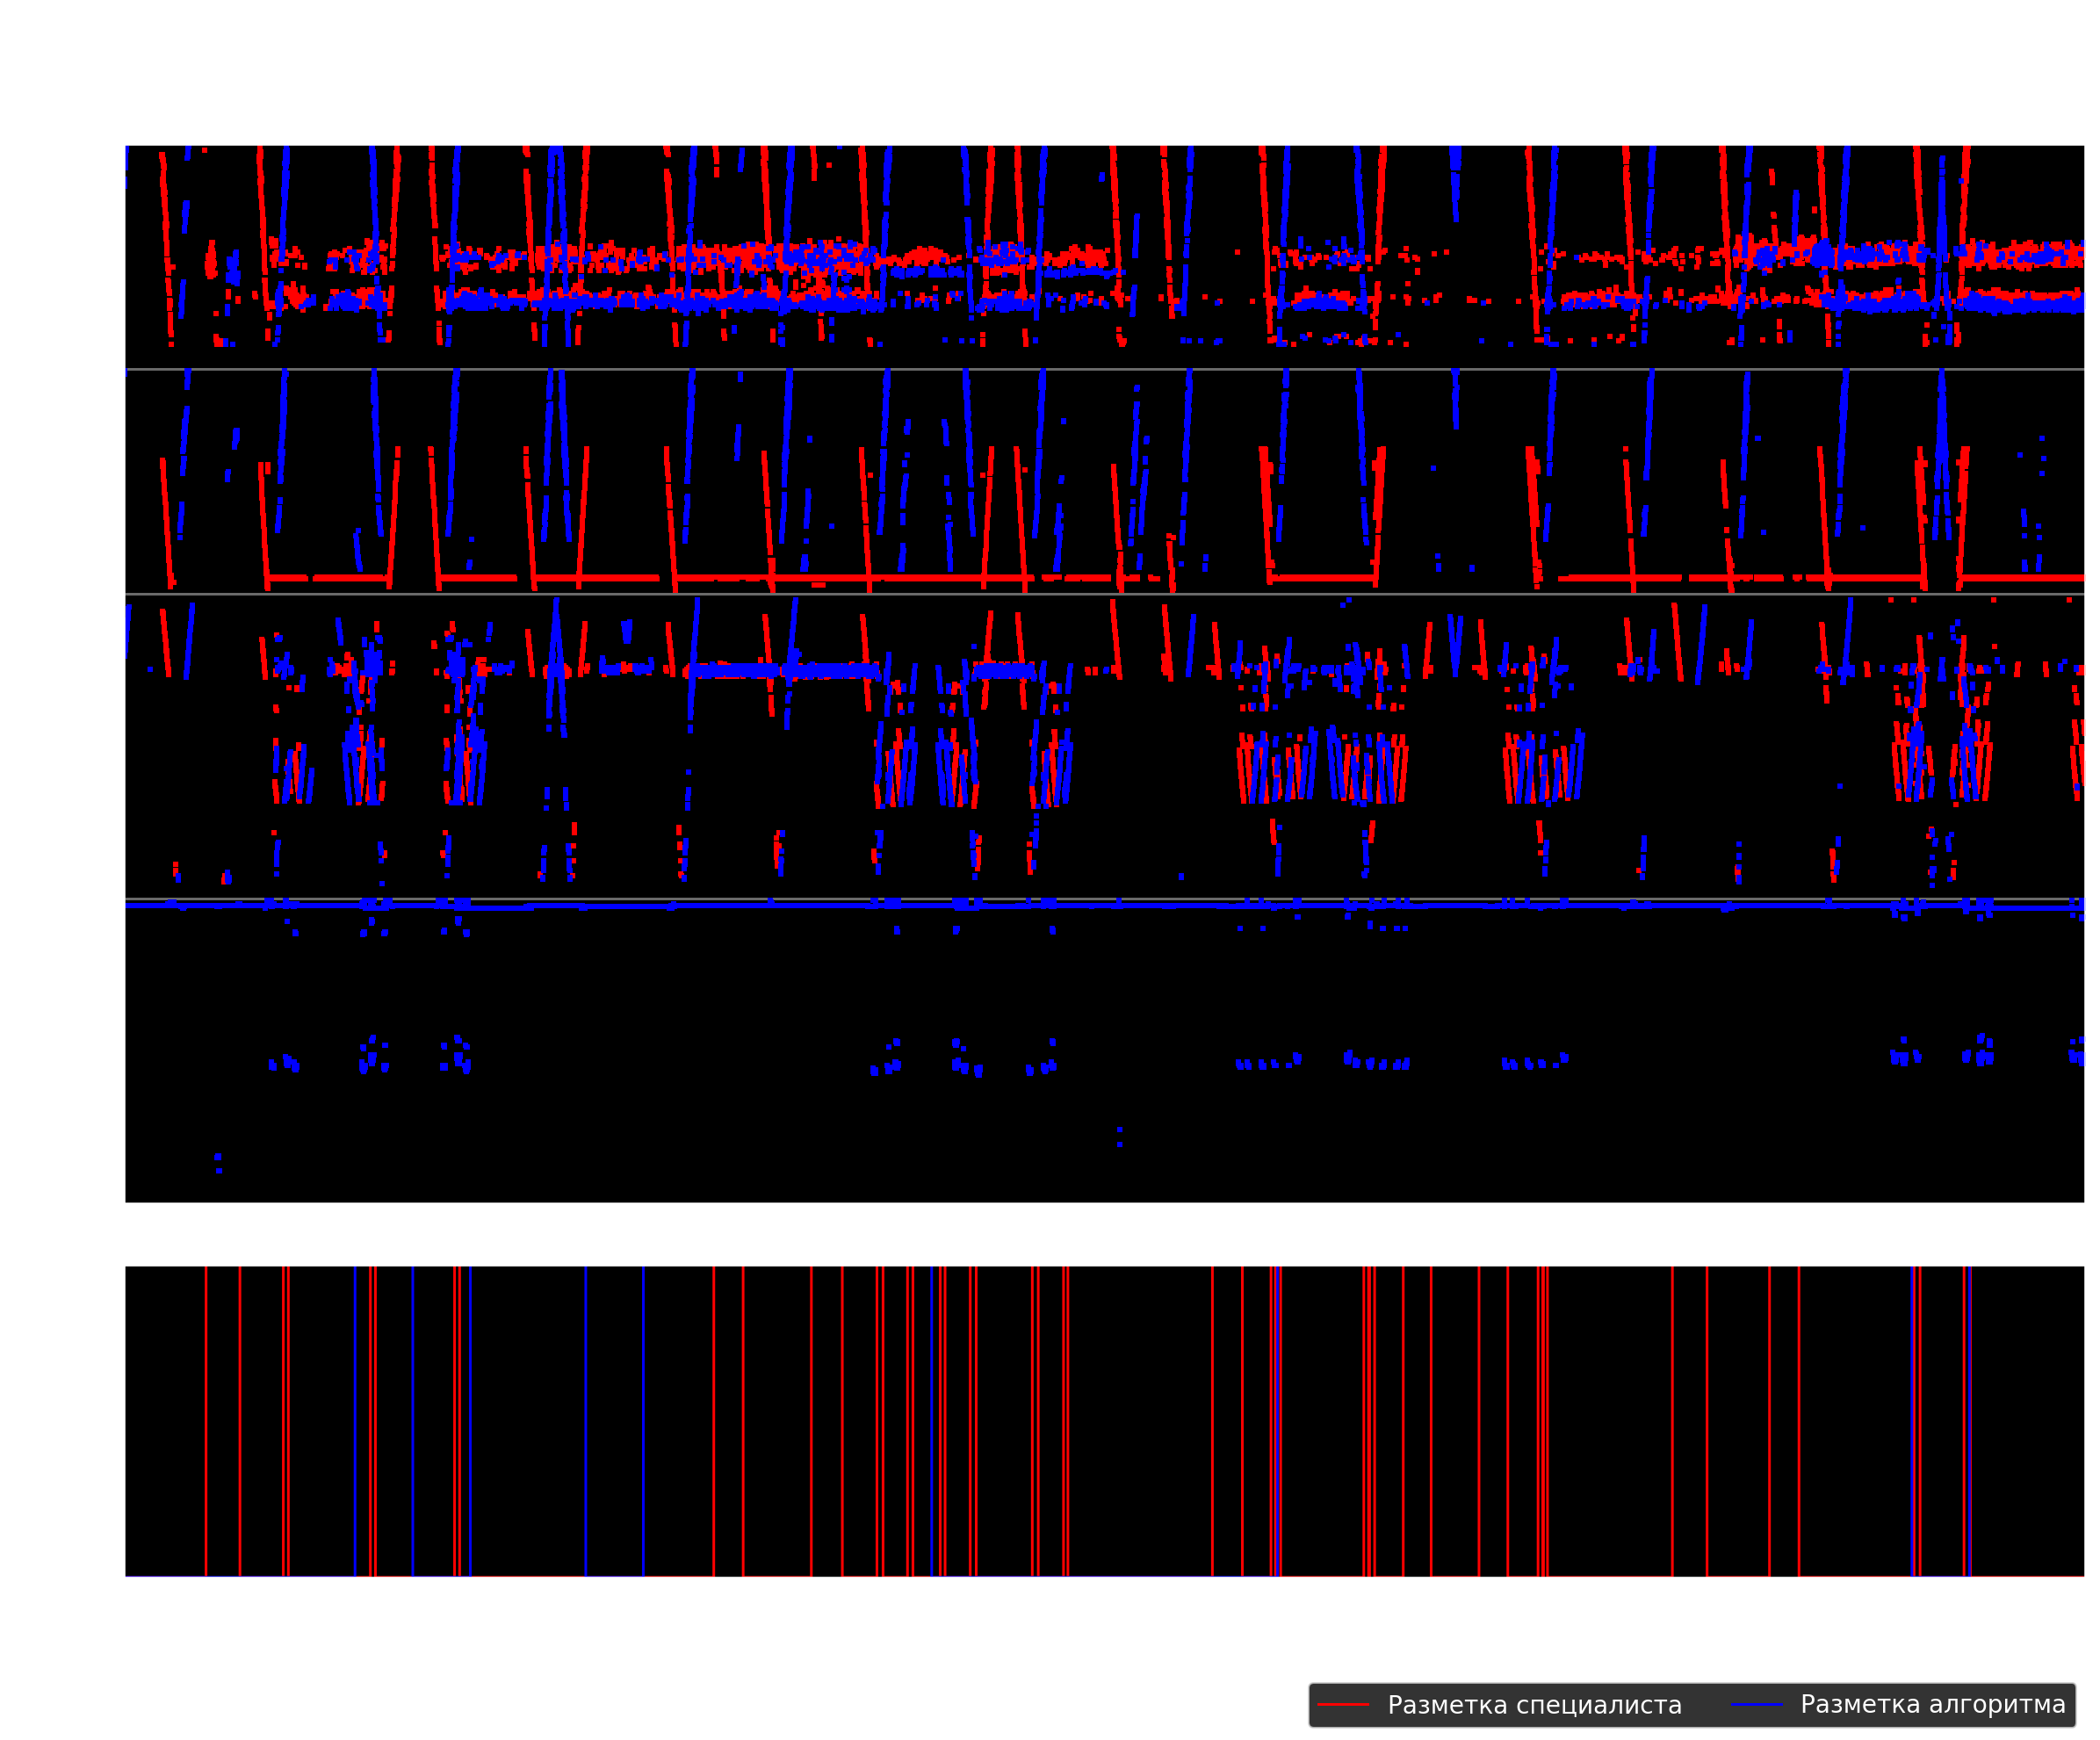

In [223]:
visualize(signal=signals[0:17000], spec_markup=true_labels.reshape(-1)[0:17000], 
          pred_markup=np.array(sequence))